In [1]:
# Standard library
import random

# Data processing and numerical computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import missingno as msno

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Machine learning models
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Feature selection
from sklearn.feature_selection import RFE, SelectKBest, f_classif

# Evaluation metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# Evolutionary algorithms
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("sph6004_assignment1_data.csv", encoding="utf-8")

In [3]:
df.drop(columns=df.columns[df.isnull().mean() > 0.50], inplace=True)
df.drop(index=df.index[df.isnull().mean(axis=1) > 0.40], inplace=True)
print(f"Final shape of df after cleaning: {df.shape}")

Final shape of df after cleaning: (50441, 90)


In [4]:
# Convert gender to a binary variable
df['gender'] = df['gender'].map({'F': 0, 'M': 1})

# Display the first 5 rows of the modified data
print(df.head())

         id  hospital_mortality  aki_stage  gender  admission_age  \
0  39553978                   0          0       0      52.559969   
1  39765666                   0          0       0      76.486231   
2  37067082                   0          0       0      55.881486   
3  31205490                   0          0       0      46.275517   
4  37510196                   1          2       0      77.018296   

                     race  heart_rate_min  heart_rate_max  heart_rate_mean  \
0                   WHITE            91.0           105.0        96.500000   
1  BLACK/AFRICAN AMERICAN            68.0            80.0        73.636364   
2                   WHITE            78.0           106.0        93.200000   
3                   WHITE            55.0            91.0        79.480000   
4  BLACK/AFRICAN AMERICAN            38.0            80.0        71.392857   

   sbp_min  ...  pt_min  pt_max  ptt_min  ptt_max  gcs_min  gcs_motor  \
0     82.0  ...    19.5    19.5     34.2   

In [5]:
race_mapping = {
    "WHITE": "WHITE",
    "WHITE - BRAZILIAN": "WHITE",
    "WHITE - EASTERN EUROPEAN": "WHITE",
    "WHITE - OTHER EUROPEAN": "WHITE",
    "WHITE - RUSSIAN": "WHITE",
    
    "BLACK/AFRICAN AMERICAN": "BLACK",
    "BLACK/AFRICAN": "BLACK",
    "BLACK/CAPE VERDEAN": "BLACK",
    "BLACK/CARIBBEAN ISLAND": "BLACK",

    "ASIAN": "ASIAN",
    "ASIAN - CHINESE": "ASIAN",
    "ASIAN - KOREAN": "ASIAN",
    "ASIAN - SOUTH EAST ASIAN": "ASIAN",
    "ASIAN - ASIAN INDIAN": "ASIAN",

    "HISPANIC OR LATINO": "HISPANIC",
    "HISPANIC/LATINO - CENTRAL AMERICAN": "HISPANIC",
    "HISPANIC/LATINO - COLUMBIAN": "HISPANIC",
    "HISPANIC/LATINO - CUBAN": "HISPANIC",
    "HISPANIC/LATINO - DOMINICAN": "HISPANIC",
    "HISPANIC/LATINO - GUATEMALAN": "HISPANIC",
    "HISPANIC/LATINO - HONDURAN": "HISPANIC",
    "HISPANIC/LATINO - MEXICAN": "HISPANIC",
    "HISPANIC/LATINO - PUERTO RICAN": "HISPANIC",
    "HISPANIC/LATINO - SALVADORAN": "HISPANIC",

    "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER": "PACIFIC_ISLANDER",
    "AMERICAN INDIAN/ALASKA NATIVE": "NATIVE_AMERICAN",

    "PORTUGUESE": "OTHER",
    "SOUTH AMERICAN": "OTHER",
    "OTHER": "OTHER",
    "MULTIPLE RACE/ETHNICITY": "OTHER",
    
    "UNKNOWN": "UNKNOWN",
    "PATIENT DECLINED TO ANSWER": "UNKNOWN",
    "UNABLE TO OBTAIN": "UNKNOWN"
}

# Apply the mapping
df["race"] = df["race"].map(race_mapping)

# Check the transformed 'race' variable
print("\n Distribution of 'race' after processing:")
print(df["race"].value_counts())
print(df["race"].unique())


 Distribution of 'race' after processing:
race
WHITE               33874
UNKNOWN              6627
BLACK                4591
OTHER                1989
HISPANIC             1711
ASIAN                1481
NATIVE_AMERICAN        87
PACIFIC_ISLANDER       81
Name: count, dtype: int64
['WHITE' 'BLACK' 'OTHER' 'UNKNOWN' 'HISPANIC' 'ASIAN' 'PACIFIC_ISLANDER'
 'NATIVE_AMERICAN']


In [6]:
# Handle missing values to ensure no NaN values
df["race"] = df["race"].fillna("UNKNOWN")

# Perform One-Hot Encoding and retain all categories
df = pd.get_dummies(df, columns=["race"], drop_first=False)

# Check the column names after One-Hot Encoding
print("\nColumn names after One-Hot Encoding:")
print([col for col in df.columns if "race_" in col])

# Ensure the correct number of One-Hot Encoding variables were generated
print("\nTotal number of One-Hot Encoding variables:", len([col for col in df.columns if "race_" in col]))

# Display the first few rows to verify the transformation
print(df.head())


Column names after One-Hot Encoding:
['race_ASIAN', 'race_BLACK', 'race_HISPANIC', 'race_NATIVE_AMERICAN', 'race_OTHER', 'race_PACIFIC_ISLANDER', 'race_UNKNOWN', 'race_WHITE']

Total number of One-Hot Encoding variables: 8
         id  hospital_mortality  aki_stage  gender  admission_age  \
0  39553978                   0          0       0      52.559969   
1  39765666                   0          0       0      76.486231   
2  37067082                   0          0       0      55.881486   
3  31205490                   0          0       0      46.275517   
4  37510196                   1          2       0      77.018296   

   heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  \
0            91.0           105.0        96.500000     82.0     95.0  ...   
1            68.0            80.0        73.636364    130.0    158.0  ...   
2            78.0           106.0        93.200000    117.0    151.0  ...   
3            55.0            91.0        79.480000   

In [7]:
# Convert all columns starting with 'race_' to int64
race_cols = df.columns[df.columns.str.startswith('race_')]
df[race_cols] = df[race_cols].astype(int).astype('int64')

# Verify the conversion
print(df.dtypes[df.columns.str.startswith('race_')])  # Check data types
print(df.head())  # Display the transformed data

race_ASIAN               int64
race_BLACK               int64
race_HISPANIC            int64
race_NATIVE_AMERICAN     int64
race_OTHER               int64
race_PACIFIC_ISLANDER    int64
race_UNKNOWN             int64
race_WHITE               int64
dtype: object
         id  hospital_mortality  aki_stage  gender  admission_age  \
0  39553978                   0          0       0      52.559969   
1  39765666                   0          0       0      76.486231   
2  37067082                   0          0       0      55.881486   
3  31205490                   0          0       0      46.275517   
4  37510196                   1          2       0      77.018296   

   heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  \
0            91.0           105.0        96.500000     82.0     95.0  ...   
1            68.0            80.0        73.636364    130.0    158.0  ...   
2            78.0           106.0        93.200000    117.0    151.0  ...   
3            55

In [8]:
# Convert 'gender' and 'hospital_mortality' to int64
df['gender'] = df['gender'].astype('int64')
df['hospital_mortality'] = df['hospital_mortality'].astype('int64')

# Check data types again
print(df.dtypes.value_counts())

# Display the final shape of the dataset
print(f"Final shape of df after cleaning: {df.shape}")

float64    85
int64      12
Name: count, dtype: int64
Final shape of df after cleaning: (50441, 97)


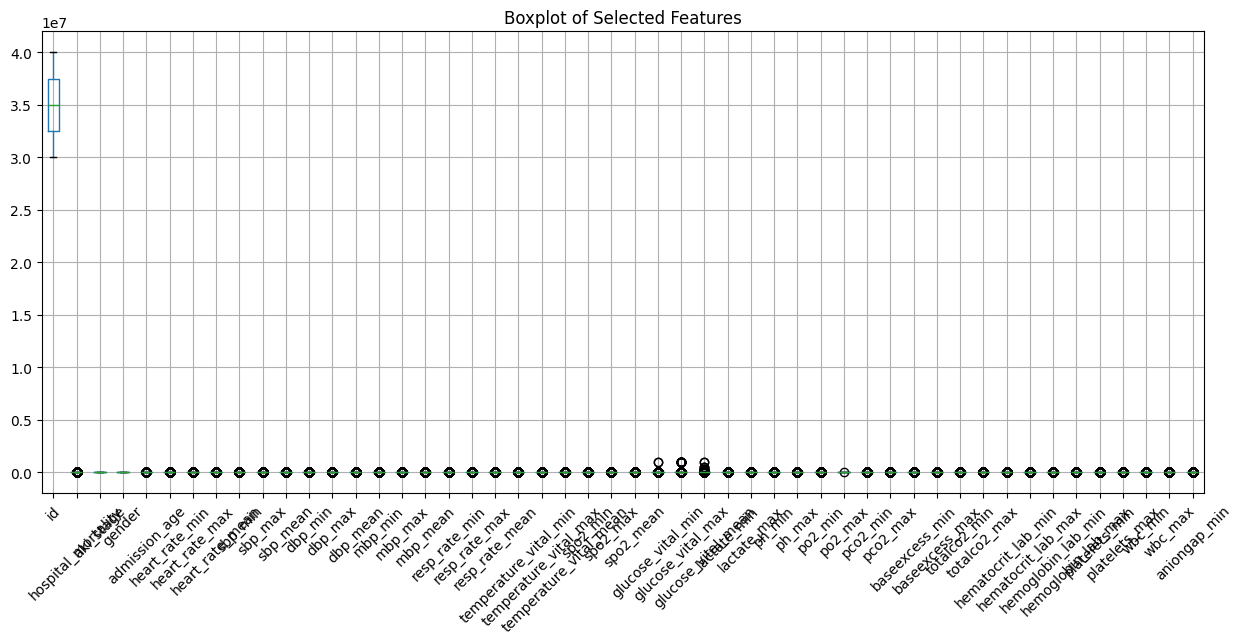

In [9]:
# Select key variables for visualization
selected_features = df.select_dtypes(include=['float64', 'int64']).columns[:50]  # View the first 50 variables (adjustable)

# Plot boxplot to check for outliers
plt.figure(figsize=(15, 6))
df[selected_features].boxplot(rot=45)
plt.title("Boxplot of Selected Features")
plt.show()

In [10]:
# Compute the maximum value for each variable
max_values = df.max().sort_values(ascending=False)

# Set a threshold (e.g., 100000) to filter variables with extremely large values
extreme_vars = max_values[max_values > 100000]  # Adjust the threshold as needed

print("Variables with extremely large values:")
print(extreme_vars)

Variables with extremely large values:
id                    39999810.0
glucose_vital_mean      999999.0
glucose_vital_min       999999.0
glucose_vital_max       999999.0
dtype: float64


In [11]:
# Remove any row containing 999999 in the specified columns
df = df[~(df[['glucose_vital_mean', 'glucose_vital_min', 'glucose_vital_max']].eq(999999)).any(axis=1)]

# Display the new dataset size to confirm row deletion
print(f"Dataset size after cleaning: {df.shape}")

Dataset size after cleaning: (50408, 97)


In [12]:
# Set a reasonable weight range (20kg to 300kg)
df = df[(df["weight_admit"] >= 20) & (df["weight_admit"] <= 300)]

# Display the dataset size after cleaning
print(f"Dataset size after cleaning: {df.shape}")

Dataset size after cleaning: (49332, 97)


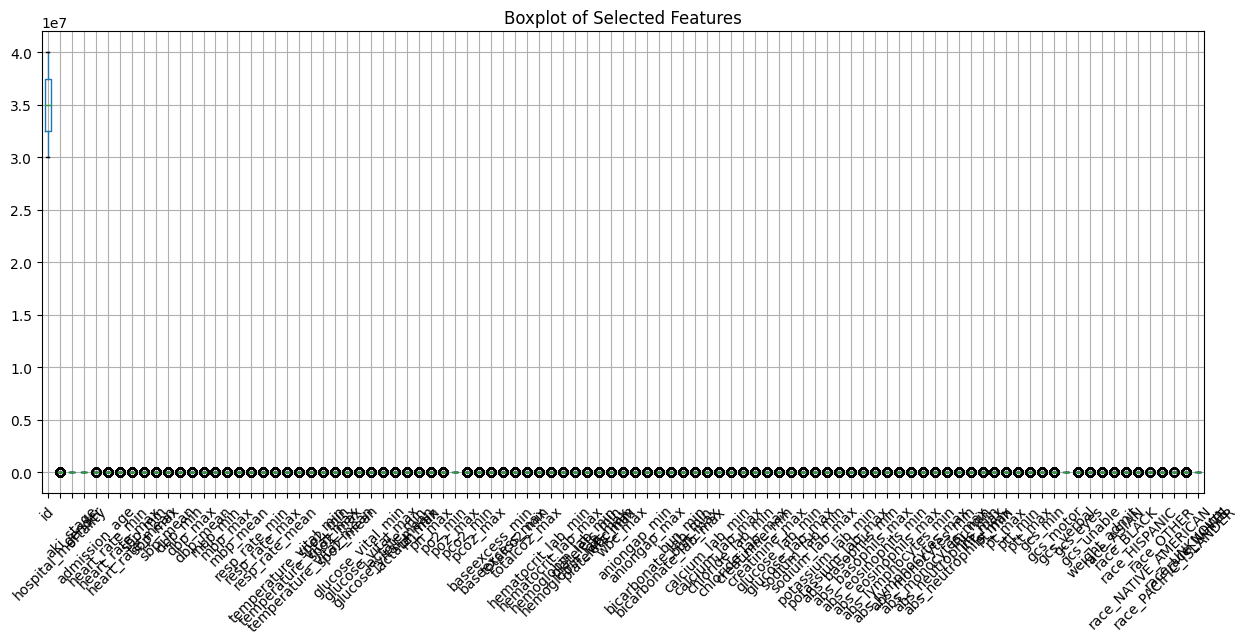

In [15]:
# Select key variables for visualization
selected_features = df.select_dtypes(include=['float64', 'int64']).columns[:97]  # View the first 50 variables (adjustable)

# Plot boxplot to check for outliers
plt.figure(figsize=(15, 6))
df[selected_features].boxplot(rot=45)
plt.title("Boxplot of Selected Features")
plt.show()

In [16]:
# Compute minimum and maximum values
min_values = df.min()
max_values = df.max()

# Select variables where the minimum value is less than -300
extreme_vars = min_values[min_values < -300].index

# Create a DataFrame showing both min and max values for these variables
extreme_df = pd.DataFrame({
    "min_value": min_values[extreme_vars],
    "max_value": max_values[extreme_vars]
}).sort_values(by="min_value")

# Display variables with a minimum value below -300 along with their maximum values
print("Variables with a minimum value below -300 and their corresponding maximum values:")
print(extreme_df)

Variables with a minimum value below -300 and their corresponding maximum values:
                min_value  max_value
baseexcess_min     -414.0       32.0
baseexcess_max     -414.0       50.0


In [17]:
# Remove rows where baseexcess_min or baseexcess_max equals -414.0
df = df[~((df["baseexcess_min"] == -414.0) | (df["baseexcess_max"] == -414.0))]

# Display the dataset size after cleaning
print(f"Dataset size after cleaning: {df.shape}")

Dataset size after cleaning: (49331, 97)


In [19]:
# Save the cleaned dataset to a CSV file
df.to_csv("1-df_特殊极端值cleaned.csv", index=False)
print("1-df_特殊极端值cleaned！")

1-df_特殊极端值cleaned！


In [20]:
# Load the cleaned dataset
df = pd.read_csv("1-df_特殊极端值cleaned.csv")

# Display the dataset size to confirm the number of rows after cleaning
print(f"Dataset size after cleaning: {df.shape}")

Dataset size after cleaning: (49331, 97)


In [21]:
# Compute the number of samples
n_samples = df.shape[0]  # Ensure df contains the dataset

# Calculate K = sqrt(n_samples) and convert it to an integer
optimal_k = int(np.sqrt(n_samples))

# Display the optimal number of neighbors
print(f"Optimal n_neighbors: {optimal_k}")

Optimal n_neighbors: 222


In [22]:
# Identify numerical variables (only these will be interpolated)
numeric_features = df.select_dtypes(include=['float64']).columns
categorical_features = [col for col in df.columns if col not in numeric_features]

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=optimal_k, weights="uniform")

# Apply KNN imputation only to numerical variables
df[numeric_features] = knn_imputer.fit_transform(df[numeric_features])

# Check for missing values after imputation
print("Missing values count (after imputation):")
print(df.isnull().sum().sort_values(ascending=False))

Missing values count (after imputation):
id                       0
hospital_mortality       0
aki_stage                0
gender                   0
admission_age            0
                        ..
race_NATIVE_AMERICAN     0
race_OTHER               0
race_PACIFIC_ISLANDER    0
race_UNKNOWN             0
race_WHITE               0
Length: 97, dtype: int64


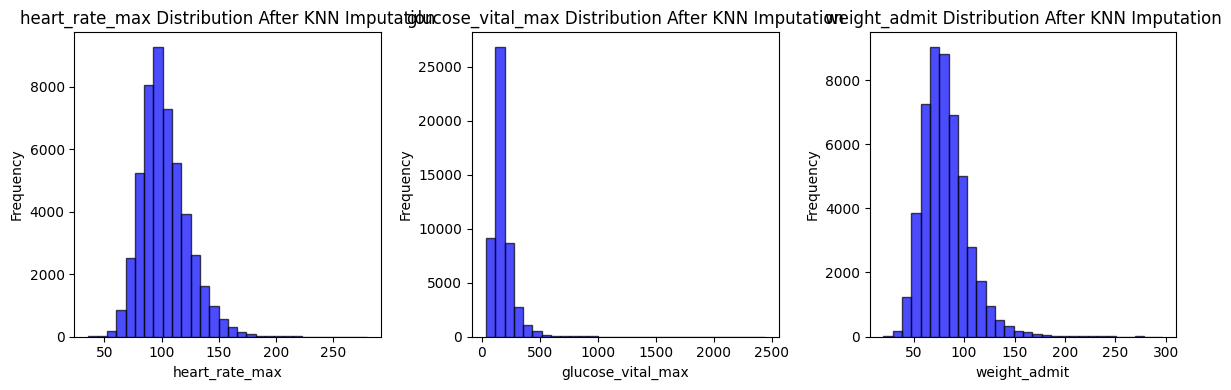

In [23]:
# Select variables for visualization
features_to_plot = ["heart_rate_max", "glucose_vital_max", "weight_admit"]

# Set figure size
plt.figure(figsize=(12, 4))

# Plot histograms for selected features
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i+1)
    plt.hist(df[feature], bins=30, alpha=0.7, color="blue", edgecolor="black")
    plt.title(f"{feature} Distribution After KNN Imputation")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

# Adjust layout and display plots
plt.tight_layout()
plt.show()


In [24]:
# Save the dataset after KNN imputation
df.to_csv("df_KNN-impute1.csv", index=False)

# Confirm that the file has been saved
print("df has been saved successfully!")


df has been saved successfully!
